# Algorithms for Massive Data
# Project - Plant Leave Recognizer
# David Fernandez - 988346

In [37]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import seed
import seaborn as sns
import random
import cv2
import os
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model

from keras.layers import PReLU
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from scikeras.wrappers import KerasClassifier

import graphviz
import pydot
import visualkeras
import urllib
from PIL import Image

In [31]:
#import data
import zipfile
import os

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

path = "D:\\Data\\"

os.environ['KAGGLE_USERNAME'] = "davidheilbron"
os.environ['KAGGLE_KEY'] = "60686e2d39aaab30b0ba19230091fcbe"
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification -p $path

with zipfile.ZipFile(os.path.join(path, 'plant-leaves-for-image-classification.zip'), 'r') as zip_ref:
    zip_ref.extractall(path)


  0%|          | 0.00/6.56G [00:00<?, ?B/s]
  0%|          | 3.00M/6.56G [00:00<03:51, 30.4MB/s]
  0%|          | 6.00M/6.56G [00:00<05:13, 22.4MB/s]
  0%|          | 10.0M/6.56G [00:00<04:08, 28.3MB/s]
  0%|          | 13.0M/6.56G [00:00<06:52, 17.0MB/s]
  0%|          | 17.0M/6.56G [00:01<07:45, 15.1MB/s]
  0%|          | 25.0M/6.56G [00:01<06:31, 17.9MB/s]
  0%|          | 33.0M/6.56G [00:01<06:13, 18.8MB/s]
  1%|          | 41.0M/6.56G [00:02<05:41, 20.5MB/s]
  1%|          | 49.0M/6.56G [00:02<05:23, 21.6MB/s]
  1%|          | 57.0M/6.56G [00:03<06:19, 18.4MB/s]
  1%|          | 65.0M/6.56G [00:03<05:44, 20.2MB/s]
  1%|1         | 73.0M/6.56G [00:03<05:25, 21.4MB/s]
  1%|1         | 81.0M/6.56G [00:04<05:23, 21.5MB/s]
  1%|1         | 89.0M/6.56G [00:04<05:53, 19.6MB/s]
  1%|1         | 97.0M/6.56G [00:04<05:17, 21.9MB/s]
  2%|1         | 105M/6.56G [00:05<05:04, 22.7MB/s] 
  2%|1         | 113M/6.56G [00:06<07:23, 15.6MB/s]
  2%|1         | 121M/6.56G [00:06<06:32, 17.6MB/s]
  2

In [6]:
#set seed
seed(2022)
tf.random.set_seed(2022)

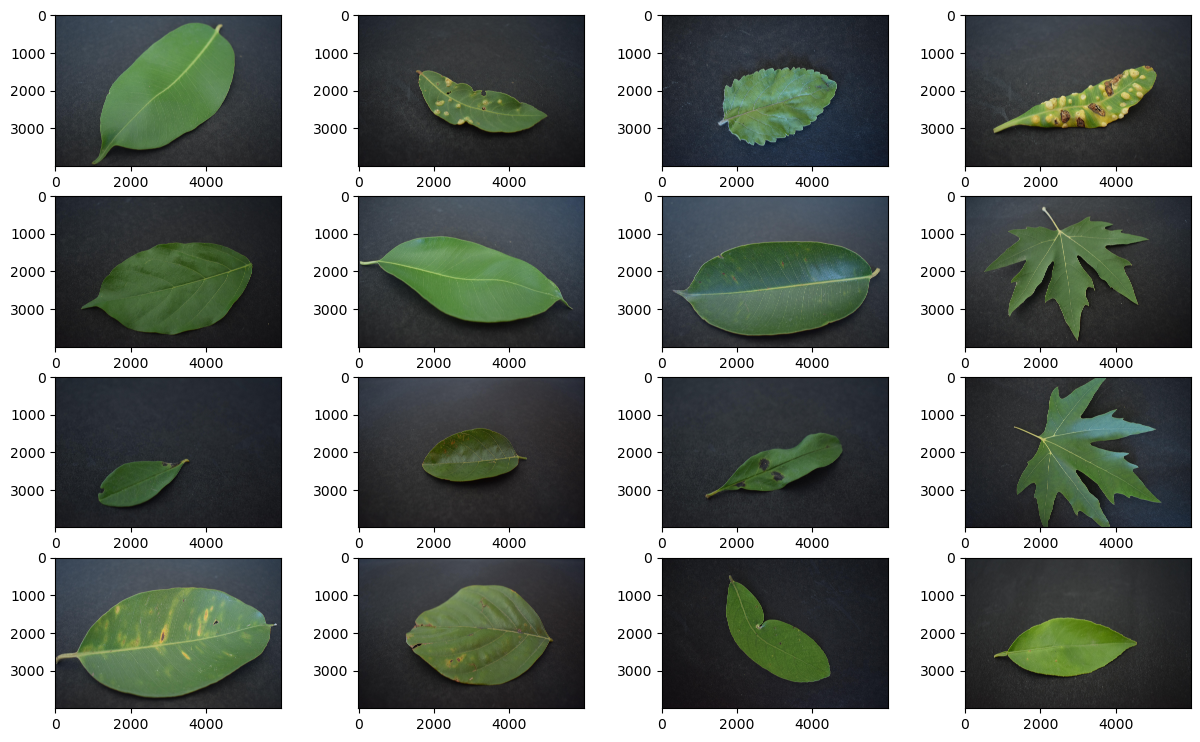

In [83]:
#show random images from training dataset
import random
from PIL import Image
from skimage.io import imread

path = r"D:\\Data\\Plants_2\\train"

images = []
for folder in os.listdir(path):
  for image in os.listdir(path + '/' + folder):
    images.append(os.path.join(path, folder, image))
      
plt.figure(1, figsize=(15, 9))
n = 0
for i in range(16):
  n += 1
  random_img = random.choice(images)
  imgs = imread(random_img)
  plt.subplot(4, 4, n)
  plt.imshow(imgs)

plt.show()

In [107]:
#HTotal number of images on each parent folder

def count_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)
    return count

path = r"D:\\Data\\Plants_2\\images to predict"
num_files = count_files(path)
print("Total number of images in images to predict", num_files)

path = r"D:\\Data\\Plants_2\\test"
num_files = count_files(path)
print("Total number of images in test", num_files)

path = r"D:\\Data\\Plants_2\\train"
num_files = count_files(path)
print("Total number of images in train", num_files)

path = r"D:\\Data\\Plants_2\\valid"
num_files = count_files(path)
print("Total number of images in valid", num_files)


Total number of images in images to predict 8
Total number of images in test 110
Total number of images in train 4274
Total number of images in valid 110


In [99]:
#How many files do we have on the test folder?

path = r"D:\\Data\\Plants_2\\test"
image_counts = {}

for root, dirs, files in os.walk(path):
    count = 0
    for file in files:
        count += 1
    if count > 0:
        image_counts[root] = count

# Display the image counts for each folder
if image_counts:
    for folder, count in image_counts.items():
        print("Folder", folder, "contains", count, "images.")
else:
    print("No images found in subfolders of", path)

Folder D:\\Data\\Plants_2\\test\Alstonia Scholaris diseased (P2a) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Alstonia Scholaris healthy (P2b) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Arjun diseased (P1a) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Arjun healthy (P1b) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Bael diseased (P4b) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Basil healthy (P8) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Chinar diseased (P11b) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Chinar healthy (P11a) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Gauva diseased (P3b) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Gauva healthy (P3a) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Jamun diseased (P5b) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Jamun healthy (P5a) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Jatropha diseased (P6b) contains 5 images.
Folder D:\\Data\\Plants_2\\test\Jatroph

In [93]:
#How many files do we have on the training folder?

path = r"D:\\Data\\Plants_2\\train"
image_counts = {}
count = 0

for root, dirs, files in os.walk(path):
    count = 0
    for file in files:
        count += 1
    if count > 0:
        image_counts[root] = count

# Display the image counts for each folder
if image_counts:
    for folder, count in image_counts.items():
        print("Folder", folder, "contains", count, "images.")
else:
    print("No images found in subfolders of", path)


Folder D:\\Data\\Plants_2\\train\Alstonia Scholaris diseased (P2a) contains 244 images.
Folder D:\\Data\\Plants_2\\train\Alstonia Scholaris healthy (P2b) contains 168 images.
Folder D:\\Data\\Plants_2\\train\Arjun diseased (P1a) contains 222 images.
Folder D:\\Data\\Plants_2\\train\Arjun healthy (P1b) contains 210 images.
Folder D:\\Data\\Plants_2\\train\Bael diseased (P4b) contains 107 images.
Folder D:\\Data\\Plants_2\\train\Basil healthy (P8) contains 137 images.
Folder D:\\Data\\Plants_2\\train\Chinar diseased (P11b) contains 110 images.
Folder D:\\Data\\Plants_2\\train\Chinar healthy (P11a) contains 93 images.
Folder D:\\Data\\Plants_2\\train\Gauva diseased (P3b) contains 131 images.
Folder D:\\Data\\Plants_2\\train\Gauva healthy (P3a) contains 267 images.
Folder D:\\Data\\Plants_2\\train\Jamun diseased (P5b) contains 335 images.
Folder D:\\Data\\Plants_2\\train\Jamun healthy (P5a) contains 268 images.
Folder D:\\Data\\Plants_2\\train\Jatropha diseased (P6b) contains 114 images.
F

In [97]:
#How many files do we have on the validation folder?

path = r"D:\\Data\\Plants_2\\valid"
image_counts = {}
count = 0

for root, dirs, files in os.walk(path):
    count = 0
    for file in files:
        count += 1
    if count > 0:
        image_counts[root] = count

# Display the image counts for each folder
if image_counts:
    for folder, count in image_counts.items():
        print("Folder", folder, "contains", count, "images.")
else:
    print("No images found in subfolders of", path)

Folder D:\\Data\\Plants_2\\valid\Alstonia Scholaris diseased (P2a) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Alstonia Scholaris healthy (P2b) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Arjun diseased (P1a) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Arjun healthy (P1b) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Bael diseased (P4b) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Basil healthy (P8) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Chinar diseased (P11b) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Chinar healthy (P11a) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Gauva diseased (P3b) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Gauva healthy (P3a) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Jamun diseased (P5b) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Jamun healthy (P5a) contains 5 images.
Folder D:\\Data\\Plants_2\\valid\Jatropha diseased (P6b) contains 5 images.
Folder D:\\Data\\Plants_2\

# Read data into pixels array, then scale and label them